In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import GridSearchCV

In [2]:
# 1) read data
cols = ["battery_capacity", "Price"]
df = pd.read_csv("../data.csv", usecols = cols)

In [3]:
# 2) exploratory data analysis

In [4]:
df.head(5)

,battery_capacity,Price
0,3000.0,100.0
1,3000.0,110.0
2,2000.0,60.0
3,4000.0,330.0
4,4000.0,130.0


In [5]:
df.describe()

,battery_capacity,Price
count,2651.000000,2651.000000
mean,3385.437948,242.896775
std,1627.512406,193.726059
min,50.000000,20.000000
25%,2070.000000,130.000000
50%,3000.000000,190.000000
75%,4500.000000,290.000000
max,11560.000000,2000.000000


<AxesSubplot: xlabel='battery_capacity', ylabel='Density'>

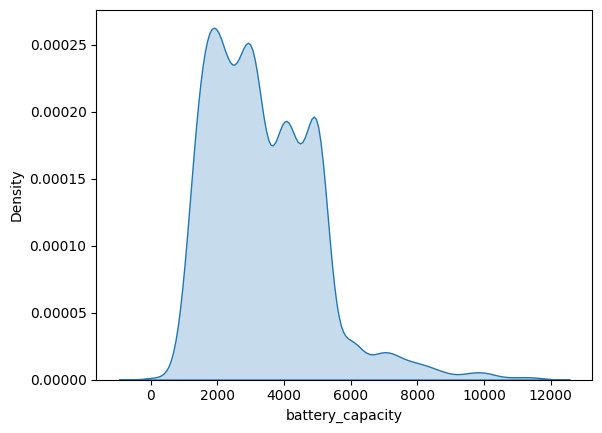

In [6]:
sns.kdeplot(df['battery_capacity'], fill=True)

<AxesSubplot: xlabel='Price', ylabel='Density'>

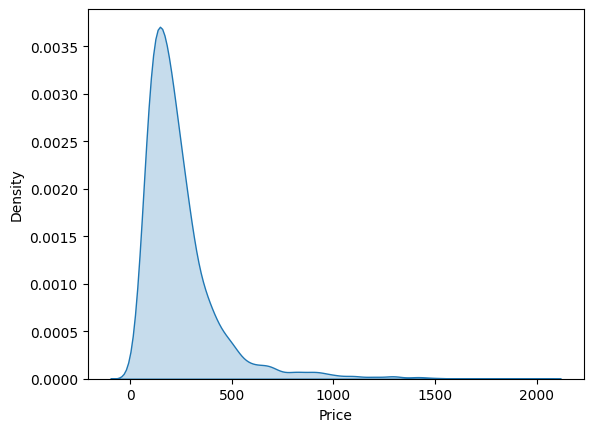

In [7]:
sns.kdeplot(df['Price'], fill=True)

<AxesSubplot: xlabel='battery_capacity'>

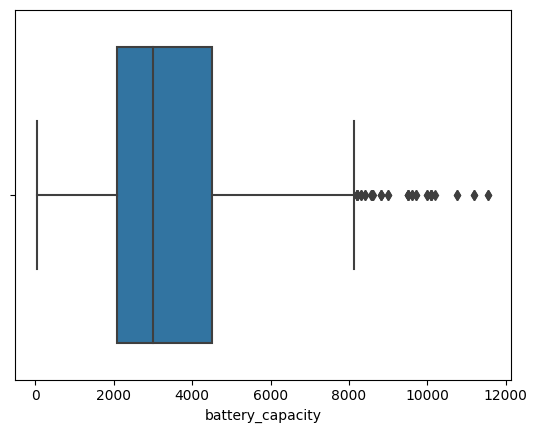

In [8]:
sns.boxplot(x=df['battery_capacity'])

<AxesSubplot: xlabel='Price'>

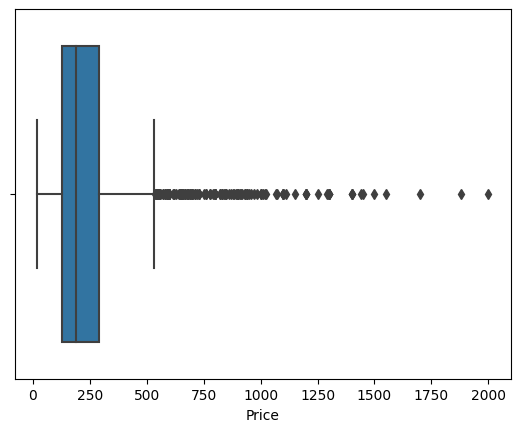

In [9]:
sns.boxplot(x=df['Price'])

Text(0, 0.5, 'Price')

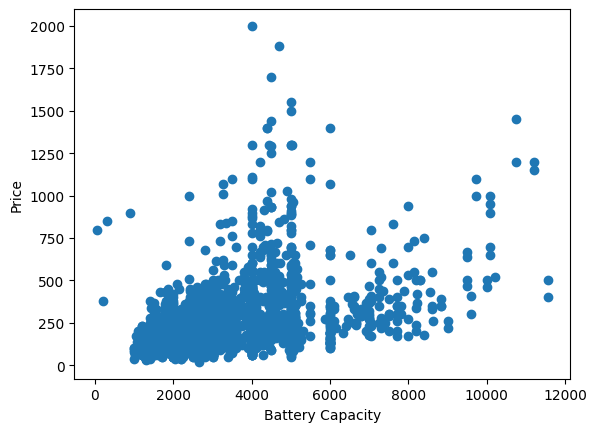

In [10]:
plt.scatter(df['battery_capacity'], df['Price'])
plt.xlabel('Battery Capacity')
plt.ylabel('Price')

<AxesSubplot: >

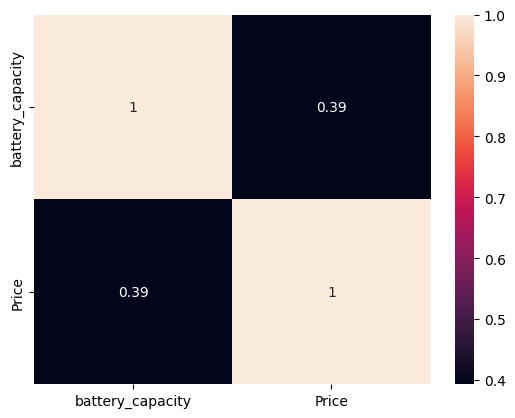

In [11]:
sns.heatmap(df.corr(), annot=True)

<div>
    <h3>
        Outlier Removal before Standardization: (Here's the rationale behind this order)
    </h3>
    <ol>
        <li>
            Outliers can significantly influence the calculation of mean and standard deviation used in standardization (or other scaling methods based on these statistics).
        </li>
        <li>
                If outliers are present, the mean and standard deviation will be skewed, leading to an incorrect standardization of the non-outlier data points.
        </li>
        <li>
               By removing outliers first, you ensure that the standardization is based on the true distribution of the non-outlier data, resulting in a more accurate scaling of the features. 
        </li>
    </ol>
</div>

<p>In our case, with the price feature having an <b>approximately normal distribution </b>and the battery_capacity feature having a <b>Gaussian Mixture Model (GMM) distribution</b>, the recommended order would be:

Remove outliers from both price and battery_capacity features using appropriate techniques (e.g.,<b> z-score for price, Probabilistic Outlier Detection and Robust Statistical Methods like Minimum Covariance Determinant (MCD) or Minimum Volume Ellipsoid (MVE) for battery_capacity</b>).</p>

<p>Removing outliers separately ensures that the unique characteristics and distributions of each feature are taken into account. It prevents the potential masking or distortion of outliers in one feature by the other feature, which could happen if you used a single combined criterion.
</p>

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   battery_capacity  2651 non-null   float64
 1   Price             2651 non-null   float64
dtypes: float64(2)
memory usage: 41.5 KB


In [13]:
# Z-score method for 'price'
z_scores = (df['Price'] - df['Price'].mean()) / df['Price'].std()
# an appropriate value based on your data
threshold = 3  
# Identify outliers
price_outliers_idx = (z_scores > threshold)

# Remove outliers
df = df[~price_outliers_idx]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 0 to 2650
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   battery_capacity  2587 non-null   float64
 1   Price             2587 non-null   float64
dtypes: float64(2)
memory usage: 60.6 KB


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(


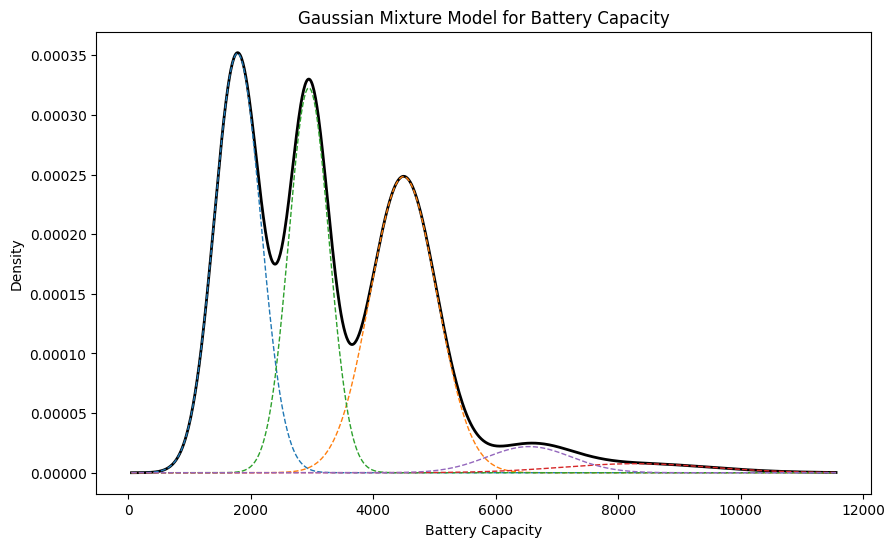

In [15]:
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

# Fit GMM to battery_capacity data
gmm = GaussianMixture(n_components=5).fit(df.battery_capacity.values.reshape(-1, 1))

# Create a meshgrid for plotting
x = np.linspace(df.battery_capacity.min(), df.battery_capacity.max(), 1000).reshape(-1, 1)

# Plot the GMM
plt.figure(figsize=(10, 6))
density = np.zeros_like(x)

for weight, mean, var in zip(gmm.weights_, gmm.means_.flatten(), gmm.covariances_.flatten()):
    density += weight * norm.pdf(x, loc=mean, scale=np.sqrt(var))

plt.plot(x, density, '-k', linewidth=2)

# Plot the individual Gaussian components
for weight, mean, var in zip(gmm.weights_, gmm.means_.flatten(), gmm.covariances_.flatten()):
    plt.plot(x, weight * norm.pdf(x, loc=mean, scale=np.sqrt(var)), '--', linewidth=1)

plt.xlabel('Battery Capacity')
plt.ylabel('Density')
plt.title('Gaussian Mixture Model for Battery Capacity')
plt.show()

In [16]:
# Calculate log-probabilities
log_prob_densities = gmm.score_samples(df.battery_capacity.values.reshape(-1, 1))

# Convert log-probabilities to probabilities
prob_densities = np.exp(log_prob_densities)

# Set probability threshold
p_threshold = 0.00001

# Identify and remove outliers
battery_capacity_idx = (prob_densities >= p_threshold)
df = df[battery_capacity_idx]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2546 entries, 0 to 2650
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   battery_capacity  2546 non-null   float64
 1   Price             2546 non-null   float64
dtypes: float64(2)
memory usage: 59.7 KB


<div>
    <h3>
        normalize or standardize numerical features for k-means and DBSCAN clustering algorithms. Here's why:
    </h3>
    <ol>
        <li>
            <b>Scale Sensitivity:</b>
            <p>Both k-means and DBSCAN are distance-based algorithms, meaning they calculate distances between data points and cluster centers (k-means) or between data points themselves (DBSCAN). If features have different scales or units, the distance calculations can be dominated by the features with larger scales, leading to biased results.</p>
        </li>
        <li>
            <b>Feature Importance:</b>
            <p>Without normalization, features with larger scales will have a larger influence on the clustering process, even though their actual importance might be lower than features with smaller scales.</p>
        </li>
    </ol>
</div>
<p>
</p>

<h3>For the price feature, which is approximately normally distributed, we can use standardization (Z-score normalization)</h3>

In [18]:
# Calculate the mean and std of 'price'
price_mean = df['Price'].mean()
price_std = df['Price'].std()

# Standardize the 'Price' column
df['price_standardized'] = (df['Price'] - price_mean) / price_std

<h3>For the battery_capacity feature, which has a GMM distribution, log transformation might be a better choice than min-max normalization or standardization. </h3>

In [19]:
# Add a small constant to avoid log(0)
c = 1  # or any other small positive value 

# Log-transform the 'battery_capacity' column
df['battery_capacity_log'] = np.log(df['battery_capacity'] + c)

# Calculate the mean and standard deviation of the log-transformed column
battery_capacity_log_mean = df['battery_capacity_log'].mean()
battery_capacity_log_std = df['battery_capacity_log'].std()

# Standardize the log-transformed column
df['battery_capacity_standardized'] = (df['battery_capacity_log'] - battery_capacity_log_mean) / battery_capacity_log_std

<AxesSubplot: xlabel='battery_capacity_standardized', ylabel='Density'>

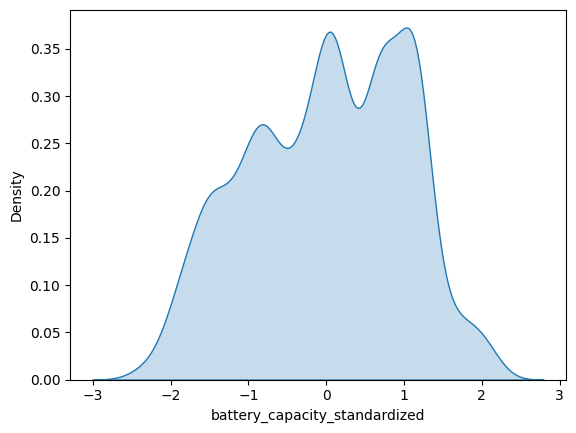

In [20]:
sns.kdeplot(df['battery_capacity_standardized'], fill=True)

<AxesSubplot: xlabel='price_standardized', ylabel='Density'>

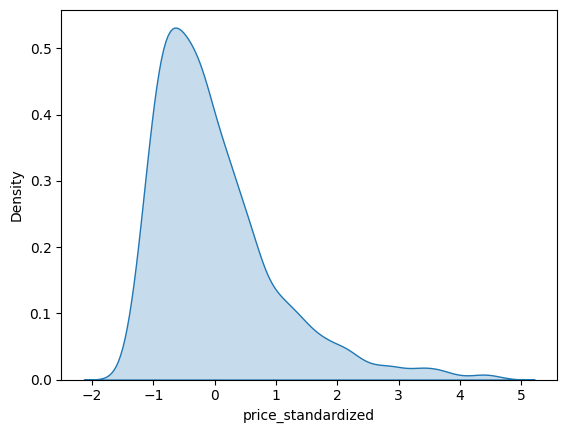

In [21]:
sns.kdeplot(df['price_standardized'], fill=True)

In [22]:
# Define parameter grid
param_grid = {
    'n_clusters': [5], 
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30],
    'max_iter': [300, 500, 1000]
}

# Instantiate grid search
grid = GridSearchCV(KMeans(), param_grid, cv=5)

# Fit grid search 
grid.fit(df[['battery_capacity_standardized', 'price_standardized']])

# Get best model
best_model = grid.best_estimator_

# Predict clusters 
clusters = best_model.predict(df[['battery_capacity_standardized', 'price_standardized']])

# Add clusters back to dataframe
df['cluster'] = clusters
best_model

KMeans(n_clusters=5, n_init=10)

In [23]:
df

,battery_capacity,Price,price_standardized,battery_capacity_log,battery_capacity_standardized,cluster
0,3000.0,100.0,-0.900929,8.006701,0.038345,3
1,3000.0,110.0,-0.824596,8.006701,0.038345,3
2,2000.0,60.0,-1.206259,7.601402,-0.853197,0
3,4000.0,330.0,0.854718,8.294300,0.670981,2
4,4000.0,130.0,-0.671932,8.294300,0.670981,1
...,...,...,...,...,...,...
2646,1500.0,140.0,-0.595599,7.313887,-1.485650,0
2647,1500.0,140.0,-0.595599,7.313887,-1.485650,0
2648,1500.0,100.0,-0.900929,7.313887,-1.485650,0
2649,1500.0,120.0,-0.748264,7.313887,-1.485650,0


In [24]:
cluster_centers = df.groupby('cluster')[['battery_capacity', 'Price']].mean().reset_index()
cluster_centers = cluster_centers.drop(["cluster"], axis=1)

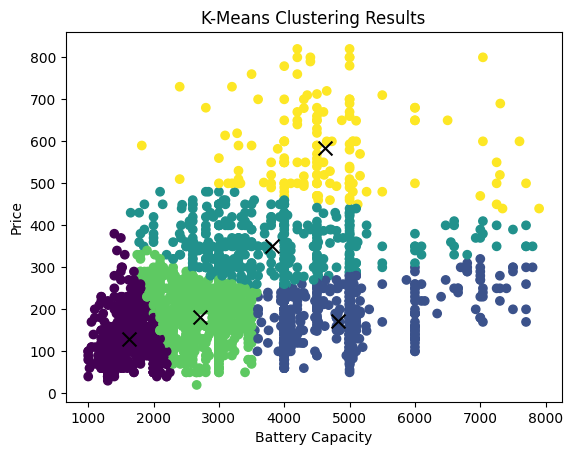

In [25]:
# Get cluster centers
centers = cluster_centers.values


# Existing plot code to visualize clusters
plt.scatter(df['battery_capacity'], df['Price'], c=df['cluster']) 
# Plot cluster centers 
plt.scatter(centers[:,0], centers[:,1], c='black', marker='x', s=100)
plt.xlabel('Battery Capacity')
plt.ylabel('Price')
plt.title("K-Means Clustering Results")

plt.show()

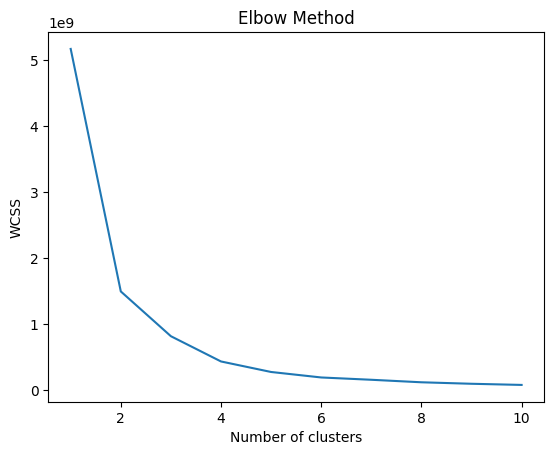

In [26]:
wcss = [] # Within cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df[['battery_capacity', 'Price']])
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

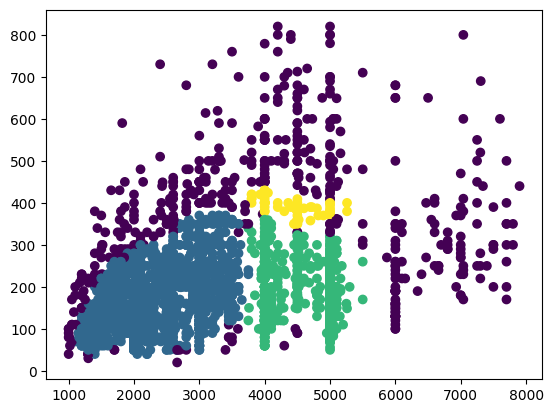

In [37]:
# Default hyperparameters 
X = df[['battery_capacity_standardized', 'price_standardized']]
dbscan = DBSCAN(eps=.16, min_samples=16) 
clusters = dbscan.fit_predict(X)

# Plot clusters
plt.scatter(df['battery_capacity'], df['Price'], c=clusters)